<a href="https://colab.research.google.com/github/diefgallegorio/Entrega_clustering/blob/master/Clustering_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clustering - Base de datos Housing**

### Procedimientos de importes de librerías y carga de la BD

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# para acceder a archivos desde google drive en google colaboratory
# acceso a google drive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Importo base de datos housing

housing = '1ruQwtMNWfV2zXdntUSPUsjk2fUrskhHM'
downloaded = drive.CreateFile({'id': housing})
downloaded.GetContentFile('housing.csv') 

#Importo archivo de funciones para housing

Misfunciones = '1aRVK0tJxxxhqKdApjTIBwrD69iOCQahP'
downloaded = drive.CreateFile({'id': Misfunciones})
downloaded.GetContentFile('Misfunciones.py') 

#Importo la función declarada en el archivo externo

from Misfunciones import pre_exploratorio_housing

#Con pandas leo la base de datos y pruebo que cargue adecuadamente
Xdata = pd.read_csv('housing.csv')
Xdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


#Partición BD
### Partición de la BD para entrenamiento y para testeo a partir de sklearn

In [0]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest = train_test_split(Xdata, test_size=0.3)
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14448 entries, 6345 to 4472
Data columns (total 10 columns):
longitude             14448 non-null float64
latitude              14448 non-null float64
housing_median_age    14448 non-null float64
total_rooms           14448 non-null float64
total_bedrooms        14311 non-null float64
population            14448 non-null float64
households            14448 non-null float64
median_income         14448 non-null float64
median_house_value    14448 non-null float64
ocean_proximity       14448 non-null object
dtypes: float64(9), object(1)
memory usage: 1.2+ MB


In [0]:
#Completo faltantes con la función importada anteriormente

col_sal='median_house_value'
col_num=['longitude','latitude','housing_median_age','total_rooms','total_bedrooms',
        'population','households','median_income']
col_cat=['ocean_proximity']

Xtrain, Ytrain= pre_exploratorio_housing(Xtrain,col_sal,col_num,col_cat,estra_num='median',estra_cat='most_frequent')
Xtest, Ytest= pre_exploratorio_housing(Xtest,col_sal,col_num,col_cat,estra_num='median',estra_cat='most_frequent')

#Codifico ordinalmente la columna categórica

from sklearn.preprocessing import OrdinalEncoder

codificador = OrdinalEncoder()
Xtrain['ocean_proximity'].value_counts()
Xtrain['ocean_proximity'] = codificador.fit_transform(Xtrain[['ocean_proximity']])
Xtrain.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14448 entries, 6345 to 4472
Data columns (total 9 columns):
longitude             14448 non-null float64
latitude              14448 non-null float64
housing_median_age    14448 non-null float64
total_rooms           14448 non-null float64
total_bedrooms        14448 non-null float64
population            14448 non-null float64
households            14448 non-null float64
median_income         14448 non-null float64
ocean_proximity       14448 non-null float64
dtypes: float64(9)
memory usage: 1.1 MB


# **MEMMAP**

### Calculo inercia con mini batch de kmeans

In [0]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans


minibatch_kmeans = MiniBatchKMeans(n_clusters=5, batch_size=50, random_state=42)

minibatch_kmeans.fit(Xtrain)

MiniBatchKMeans(batch_size=50, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [0]:
# from tempfile import mkdtemp
# import os.path as path
# filename = path.join(mkdtemp(), 'my_mnist.data')
# X_mm     = np.memmap(filename, dtype='float32', mode='write', shape=Xtrain.shape)
# X_mm[:]  = Xtrain

# minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
# minibatch_kmeans.fit(X_mm)

In [0]:
minibatch_kmeans.inertia_

19318671724.91015

# **KMEANS**

### Aplico algoritmo de clasificación no supervisada, kmeans

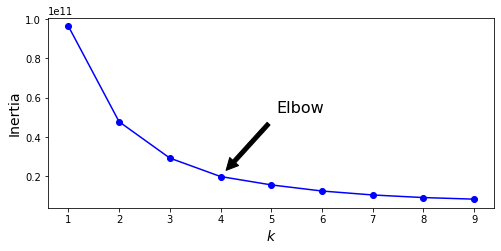

In [0]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(Xtrain)
                for k in range(1, 10)]
inertias     = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
# plt.axis([1, 8.5, 0, 1300])
#save_fig("inertia_vs_k_plot")
plt.show()

# **Silueta**

### Reviso la calidad de la clasificación realizada anteriormente, a través de silhouette score 

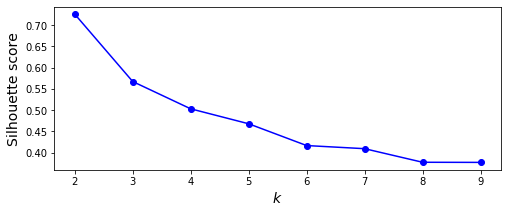

In [0]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(Xtrain, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
# plt.axis([1.8, 8.5, 0.55, 0.7])
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# **Estimación del óptimo de número de grupos en el Kmeans**

### Evaluo con diferentes cantidades de reparticiones el algoritmo aplicado anteriormente

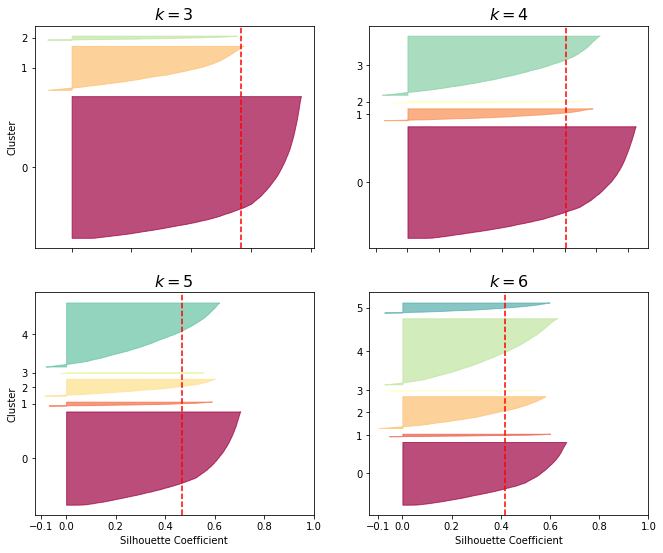

In [0]:
import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred                  = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(Xtrain, y_pred)

    padding = len(Xtrain) // 30
    pos     = padding
    ticks   = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

#save_fig("silhouette_analysis_plot")
plt.show()